In [2]:
import warnings
from collections import namedtuple
from math import ceil

warnings.simplefilter(action="ignore", category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from algorithms.snn import SNN
from algorithms.snn_biclustering import SNNBiclustering
from algorithms.fill_tensor_ALS import ALS
from sklearn.metrics import r2_score
import time
from synthetic_data_generation.generate_eval import (
    sales_data_staggering_assignment,
    sales_data_si_assignment,
    sales_data_random_assignment,
    get_sales_data,
)

Metric = namedtuple(
    "Metric",
    "train_time  query_time r2 mse number_estimated_entries number_estimated_feasible_entries",
)
ALG_REGISTRY = {"SNN": SNN, "SNNBiclustering": SNNBiclustering, "ALS": ALS}




In [3]:

def evaluate_partial(
    data_gen,
    data_assignment,
    algorithm,
    repeat,
    datasize,
    chunk_size,
    drifts = None,
    same_sub_space_regimes = False
):
    # get indices to adjust tensor
    no_batches = ceil((datasize) / chunk_size)
    scores = np.zeros([no_batches, repeat])
    for i in range(repeat):
        data = data_gen(seed=i, N=100, T=datasize, drifts = drifts, same_sub_space_regimes = same_sub_space_regimes)
        if i != 0:
            if algorithm == "SNN":
                model._get_anchors.cache.clear()
                model._get_beta.cache.clear()
            elif algorithm == "SNNBiclustering":
                model._map_missing_value.cache.clear()
                model._get_beta_from_factors.cache.clear()
        model = ALG_REGISTRY[algorithm](verbose=False)
        start = 0
        for batch in range(no_batches):
            end = min(start + chunk_size - 1, datasize - 1)
            batch_tensor, full_df = data.generate([start, end])
            periods = data_assignment(data, seed=i * (batch + 1), T=end - start + 1)
            
            ss_tensor, df_batch = data.auto_subsample(periods, batch_tensor, full_df)
            batch_mask = data.mask

            batch_mask = batch_mask.astype(bool)
            t = time.perf_counter()
            if batch == 0:
                mask = batch_mask.copy()
                tensor = batch_tensor.copy()
                model.fit(
                    df=df_batch,
                    unit_column="unit_id",
                    time_column="time",
                    metrics=["sales"],
                    actions=["ads"],
                )
                indices = [model.actions_dict[action] for action in ["ad 0", "ad 1", "ad 2"]]
    
            else:
                mask = np.concatenate([mask, batch_mask], axis=1)
                tensor = np.concatenate([tensor, batch_tensor], axis=1)
                model.partial_fit(df_batch)
            _tensor_est = model.get_tensor_from_factors(time_idx = list(range(start, end+1)))
            tensor_est = _tensor_est[:, :, indices]
            notnan = ~np.isnan(tensor_est)
            tensor_true = tensor[:,start:end+1,:,0]
            mask_t = mask[:,start:end+1,:,0]
            score = r2_score(
            tensor_true[notnan][~mask_t[notnan]].flatten(),
            tensor_est[notnan][~mask_t[notnan]].flatten(),
        )
            scores[batch, i] = score
        
            start = end + 1

    return scores, model

Generated 423 clusters
Evaluate SNNBiclustering for random


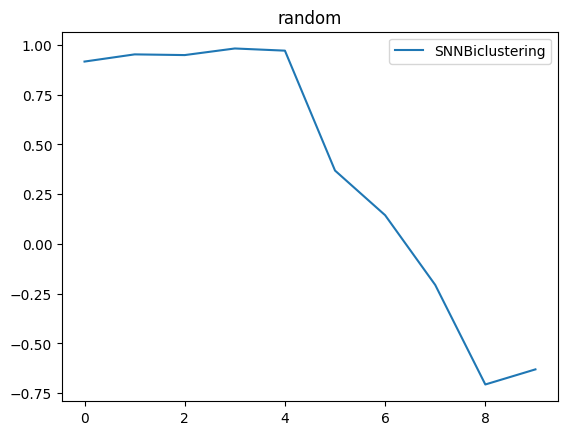

In [4]:



# data examples
datasets_assignment_generators = [
    sales_data_si_assignment,
    sales_data_staggering_assignment,
    sales_data_random_assignment,
]
data_names = ["SI sparsity", "staggered", "random"]
num_datasets = len(datasets_assignment_generators)

algorithms = ["SNNBiclustering"]
chunksize = [200]
datasize = 2000
data_gen = get_sales_data
drifts = [1000]
repeat = 1
for k, data_assignment in enumerate(datasets_assignment_generators[:]):
    if k < 2:continue
    plt.figure()
    plt.title(data_names[k])
    for alg in algorithms:
            for chunk_size in chunksize:
                ## Temp solution for mask problem
                r2_scores, model = evaluate_partial(
                    data_gen,
                    data_assignment,
                    alg,
                    repeat,
                    datasize,
                    chunk_size,
                    drifts
                )
                print(f"Evaluate {alg} for {data_names[k]}")
                plt.plot(r2_scores.mean(1), label = alg)
    plt.legend()
            
                




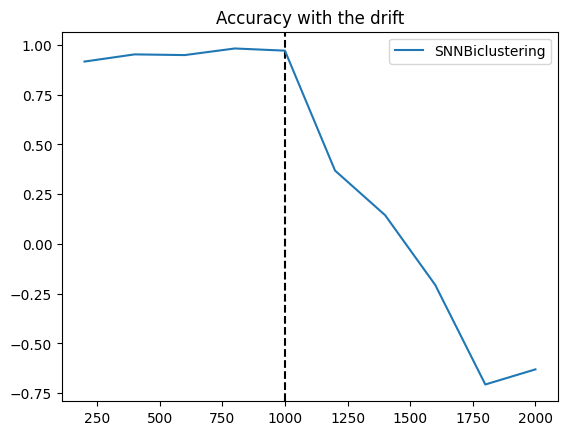

In [5]:
plt.figure()
plt.title("Accuracy with the drift")
T = np.linspace(chunk_size, datasize, datasize//chunk_size )
plt.axvline(drifts, linestyle = "dashed", color = "k")
plt.plot(T,r2_scores.mean(1), label = alg)
plt.legend()
plt.savefig("accuracyWithDrift.png")


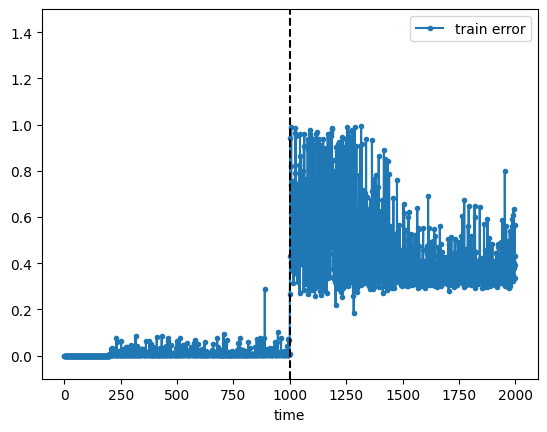

In [7]:
plt.plot(model.distance_error, '.-', label = "train error")
plt.axvline(drifts, linestyle = "dashed", color = "k")
plt.ylim([-0.1,1.5])
plt.legend()
plt.xlabel("time")
plt.savefig("distances.png")

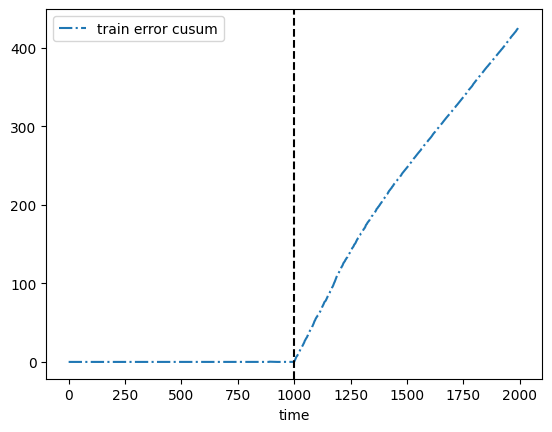

In [8]:


plt.plot(model.cusum, '-.', label = "train error cusum")
plt.axvline(drifts, linestyle = "dashed", color = "k")
# plt.ylim([-0.1,1.5])
plt.legend()
plt.xlabel("time")
plt.savefig("cusums.png")